In [1]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [2]:
class MyModel(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super(MyModel, self).__init__(*args, **kwargs)

    def grad_loss_eq(self, gradx, x_batch_train, vf_batch_train):
        # LHS of eq 6.4
        # divided by D
        # g_loss = tf.math.reduce_sum(tf.math.square(tf.math.reduce_sum(gradx*vf_batch_train,axis=1) + tf.math.reduce_sum(tf.math.square(x_batch_train), axis=1))) / len(x_batch_train)
        g_loss = tf.math.reduce_sum(tf.math.square(tf.math.reduce_sum(gradx*vf_batch_train,axis=0) + tf.math.reduce_sum(tf.math.square(x_batch_train), axis=0))) / len(x_batch_train)

        return g_loss

    def train_step(self, x_batch_train, vf_batch_train):

        # start gradient recording for derivative w.r.t. model parameters
        with tf.GradientTape() as tape:

            # evaluate model
            # try trainable = False
            logits = self(x_batch_train)

            # start gradient recording for derivative w.r.t. x
            with tf.GradientTape() as tapex:

                # prepare for evaluation of x-derivative
                tapex.watch(x_batch_train)
                # not sure if training should be false here.
                logits2 = self(x_batch_train)

                # evaluate x-derivative
                gradx = tapex.gradient(logits2, x_batch_train)

                # evaluate PDE part of loss function
                gloss = self.grad_loss_eq(gradx, x_batch_train, vf_batch_train)
                # this is the w in the loss equation   
                gradweight = 1
                loss_value =  gradweight * gloss

        # evaluate derivative w.r.t. model parameters
            grads = tape.gradient(loss_value, self.trainable_weights)

        # Run one step of gradient descent optimizer
            sgd = tf.keras.optimizers.SGD(learning_rate=0.0005)
            opt = tf.keras.optimizers.Adam(learning_rate=0.05)
            # opt.apply_gradients(zip(grads, self.trainable_weights))
            sgd.apply_gradients(zip(grads, self.trainable_weights))


        return(loss_value,gloss)
    
    def test_step(self, x_test, vf_test):

        y_pred = self(x_test, training=False)

        with tf.GradientTape() as tapex:

            tapex.watch(x_test)
            # not sure if training should be false here.
            logits2 = self(x_test, training =False)

            # evaluate x-derivative
            gradx = tapex.gradient(logits2, x_test)

            loss = self.grad_loss_eq(gradx, x_test, vf_test)
        return 1 * loss

In [3]:
class Create_Data():
    
    def __init__(self, vf, dim):
        super(Create_Data, self).__init__()
        self.vf = vf
        self.dim = dim
    
    def create_raw_data(self, train_n, bounds, test_n):
        # n is the number of points, bounds is a list of bounds for the d-dimensional data
        if self.dim == 2:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n)]).T
        elif self.dim == 3:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n),  np.random.uniform(-bounds[2],bounds[2],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n),  np.random.uniform(-bounds[2],bounds[2],test_n)]).T
        elif self.dim == 1:
            omega_domain = np.random.uniform(-bounds[0], bounds[0],train_n)
            test_omega_domain = np.random.uniform(-bounds[0], bounds[0],test_n)
        else:
            return('wrong dimensions')
        vfdata = self.vf(omega_domain)
        tdata = tf.convert_to_tensor(omega_domain, dtype=tf.float32)
        tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))
        test_vfdata = self.vf(test_omega_domain)
        test_tdata = tf.convert_to_tensor(test_omega_domain, dtype=tf.float32)
        test_tvf     = kb.transpose(tf.convert_to_tensor(test_vfdata, dtype=tf.float32))

        train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
        test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_tdata, test_tvf))

        return train_dataset_raw, test_dataset_raw
    
    def shuffle_and_batch_dataset(self, dataset, batch_size, shuffle_buffer=None):
        if shuffle_buffer:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer)
            
        dataset = dataset.batch(batch_size)
        return(dataset)
        

In [4]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape, name = 'state')
    # h = inputs
    # h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
    #                           kernel_initializer=tf.random_normal_initializer,
    #                           bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
    #                           trainable=True)(inputs)
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, trainable=False)(inputs)
    # h = np.sqrt(2) * h
    for units in hidden_units:
        # h = tf.keras.layers.Dense(units, activation='selu', 
        #                           kernel_regularizer=tf.keras.regularizers.l2(l2_reg_coeff))(h)
        h = tf.keras.layers.Dense(units, activation='linear')(h)
        # h = tf.keras.layers.BatchNormalization()(h)
        # h = tf.keras.layers.Dropout(dropout_rate)(h)
    # outputs = tf.keras.layers.Dense(10, activation=None)(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    if m >= 1000:
        # only divide by m if the number of neurons exceeds a certain threshold
        print('ep!!!')
        outputs = outputs / m
    # model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model = MyModel(inputs=inputs, outputs=outputs)

    return model

In [5]:

# model = get_regularised_bn_mlp(input_shape=2, m = 200, hidden_units= [])
# model.summary()

In [6]:
def custom_training_loop(model, epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    start = time.perf_counter()

    # loop through the epochs
    for epoch in range(epochs):

        # initialize error variables, mlv=maximum (L_infty), slv = L_1
        mlv = 0.0
        slv = 0.0
        
        # Iterate over the batches of the dataset
        for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            [loss_value,gloss] = model.train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())


            # update errors
            # # mlv = kb.max([mlv,loss_value],0)
            # mlv = tf.math.reduce_max([mlv,loss_value],0)
            # # mlv = tf.math.maximum([mlv,loss_value],0)

            slv = slv + loss_value

        for step, (x_test, vf_test) in enumerate(validation_dataest):
            test_loss = model.test_step(x_test, vf_test)
            all_test_loss_values.append(test_loss)

        # print log information at end of epoch    
        # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
        if epoch % 100 == 0:
            # print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))
            print('epoch {} and loss {}'.format(epoch, loss_value.numpy()))


        # # terminate if L_infty error is sufficiently small
        # if mlv < tol:
        #     print('op')
        #     break

    print("End of training, time: {:.4f}".format(time.perf_counter() - start))
    return all_loss_values, all_test_loss_values

In [18]:
# parameters
# dimensions of the problem 
dim = 1
# number of neurons of 1st layer
m = 200
# number of neurons of subsequent layers
hidden_u = []
# number of data points
n = 900
# bounds of the x1 and x2
bounds = [2]
# number of points for the test dataset
test_n =90
batch_n = 90
buff = 1024
epochs = 500
tol = 1e-5

# 1d

def vf(x):
    y = np.piecewise(x, [x ==0, x!=0], [0, lambda x: -np.square(x) / np.sin(x)])
    return y

In [19]:
model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 200)               400       
                                                                 
 output_layer (Dense)        (None, 1)                 200       
                                                                 
Total params: 600
Trainable params: 200
Non-trainable params: 400
_________________________________________________________________


epoch 0 and loss 104.69984436035156
epoch 100 and loss 0.013481358997523785
epoch 200 and loss 0.027817191556096077
epoch 300 and loss 0.28843721747398376
epoch 400 and loss 0.03588790446519852
End of training, time: 35.8545


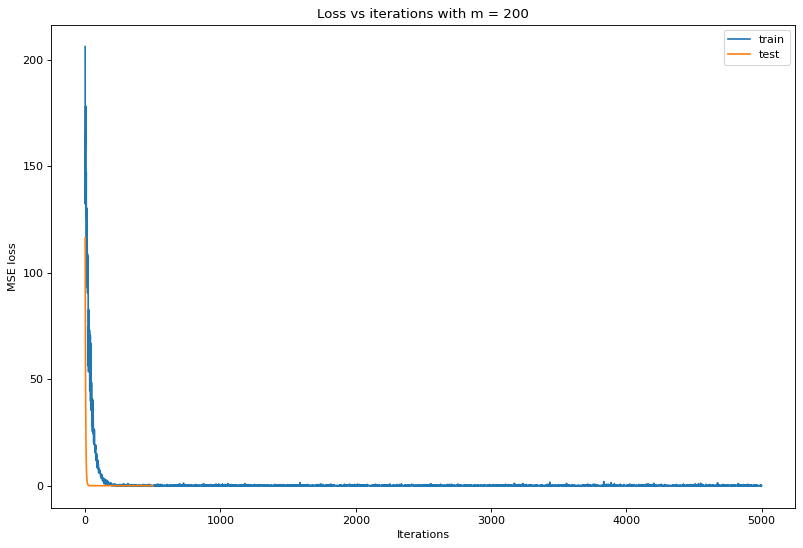

In [20]:
my_data = Create_Data(vf, dim)
tr, te = my_data.create_raw_data(n, bounds, test_n)
tr = my_data.shuffle_and_batch_dataset(tr, batch_n, buff)
te = my_data.shuffle_and_batch_dataset(te, batch_n)

all_loss_values, all_test_loss_values = custom_training_loop(model, epochs, tol, tr, te)

plt.plot(all_loss_values, label = 'train')
plt.plot(all_test_loss_values, label = 'test')
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

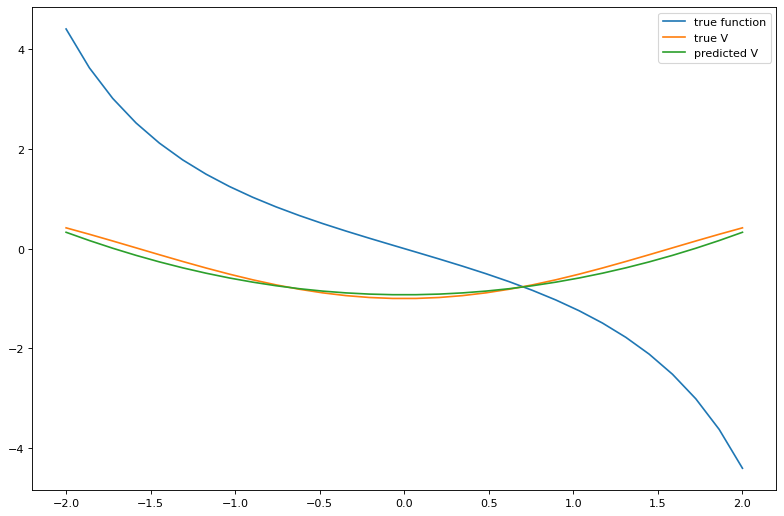

In [23]:
# 1d
# define resolution
numpoints = 30

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
v_pred = model.predict(x)

v_pred = v_pred + 34.5

def v_true_f(x):
    vtf = - np.cos(x)
    return vtf
v_true = v_true_f(x)
y_true = vf(x)

plt.plot(x, y_true, label = 'true function')
plt.plot(x, v_true, label = 'true V')
plt.plot(x, v_pred, label = 'predicted V')
plt.legend()
plt.show()

In [13]:
vf(0)

array(0)